In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import VARMAX
import matplotlib.pyplot as plt

(array([24366210, 24367680, 24406200], dtype=int64),
 [Text(24366210, 0, ''),
  Text(24367680, 0, '01\nMay\n2016'),
  Text(24406200, 0, '')])

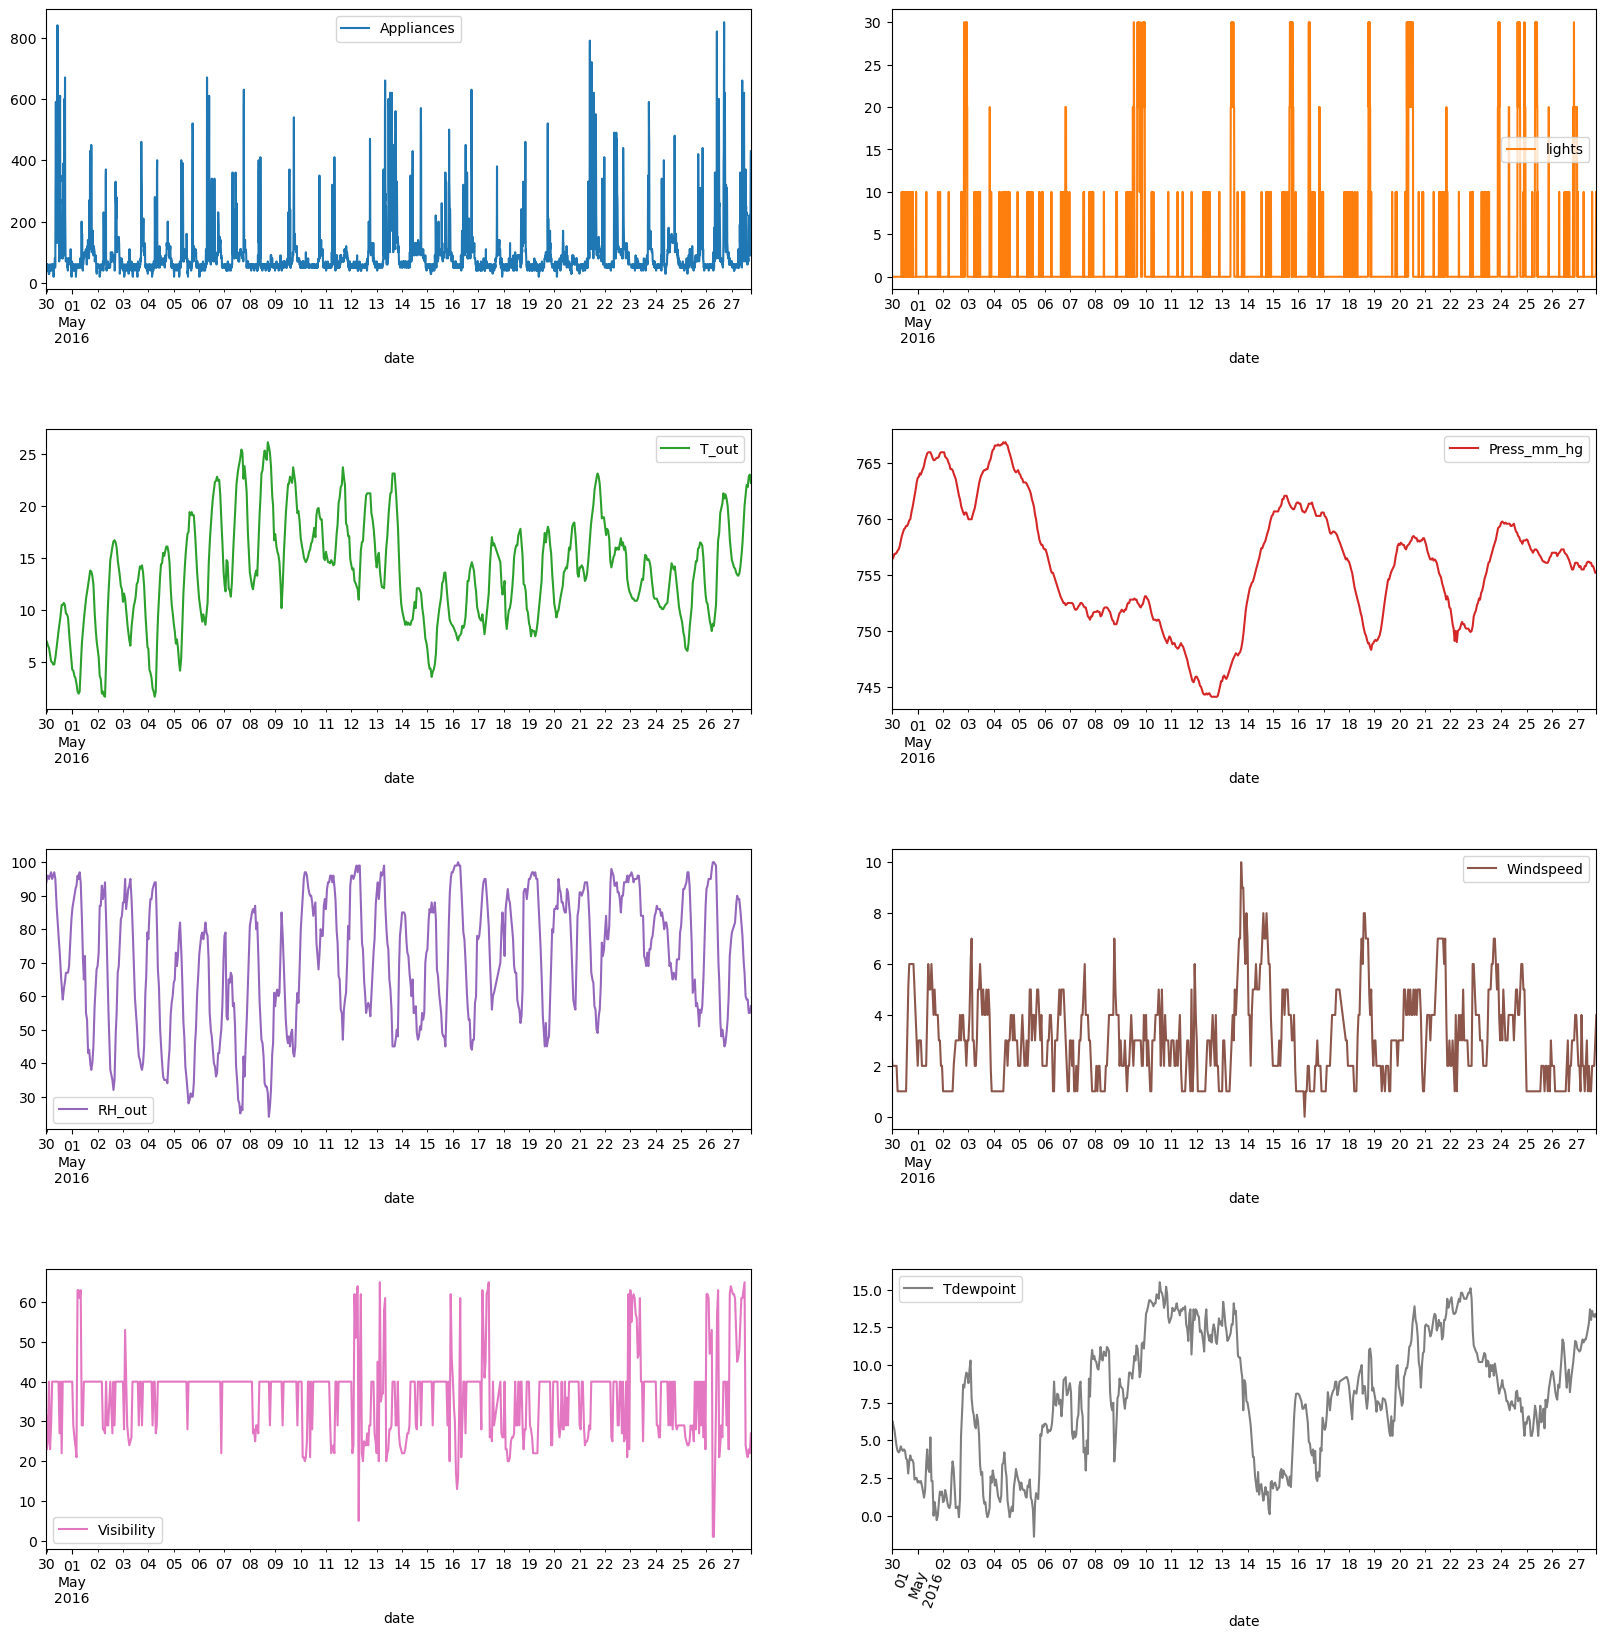

In [2]:

df = pd.read_csv("energydata_complete.csv")

df.set_index("date", inplace=True)

df = df[["Appliances", "lights", "T_out", "Press_mm_hg", "RH_out", "Windspeed", "Visibility", "Tdewpoint"]]

df = df.iloc[-4000:, :]

df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots(figsize=(20,20), nrows=4, ncols=2)


df.plot(subplots=True, ax=ax)
fig.subplots_adjust(hspace=.5)
plt.xticks(rotation=70)

In [3]:
from statsmodels.tsa.stattools import adfuller as adf

for col in df.columns:
    pvalue = adf(df[col].values)[1]
    if pvalue > .05:
        print("difference column: ", col)

difference column:  Press_mm_hg
difference column:  Tdewpoint


In [4]:
df["Press_mm_hg"] = df["Press_mm_hg"].diff()
df["Tdewpoint"] = df["Tdewpoint"].diff()
df = df.dropna(axis=0)

In [5]:
#examine which features to use in the multivariate time series model
df.corr()

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
Appliances,1.000000,0.068785,0.209460,-0.007358,-0.205268,0.162395,0.036952,0.000956
lights,0.068785,1.000000,0.071808,0.029489,-0.035866,0.057214,-0.022434,0.064651
T_out,0.209460,0.071808,1.000000,-0.265106,-0.606443,0.283010,0.044654,0.017332
Press_mm_hg,-0.007358,0.029489,-0.265106,1.000000,0.203299,0.087058,0.015905,-0.012162
RH_out,-0.205268,-0.035866,-0.606443,0.203299,1.000000,-0.362044,-0.087680,0.004477
Windspeed,0.162395,0.057214,0.283010,0.087058,-0.362044,1.000000,0.006493,-0.105782
Visibility,0.036952,-0.022434,0.044654,0.015905,-0.087680,0.006493,1.000000,0.008279
Tdewpoint,0.000956,0.064651,0.017332,-0.012162,0.004477,-0.105782,0.008279,1.000000


In [19]:
from sktime.split import TemporalTrainTestSplitter

df = df[["Appliances", "T_out", "RH_out", "Windspeed"]]

splitter = TemporalTrainTestSplitter(test_size=.2)

split = splitter.split(df)

scores = dict()

#find best order of ar and ma terms using aic scores 
for train_indices, test_indices in split:
    for p in range(1,4):
        for q in range(1,4):
            model=VARMAX(endog=df.iloc[:len(train_indices), :], order=(p,q)).fit()
            scores[f"AR: {p} MA:{q}"] = model.aic

#print the best scoring order of auto regressive and moving average terms
print(min(scores, key=scores.get))

#model.summary()

C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\egrah\anaconda3

AR: 3 MA:3


In [22]:
#fit the final model to be used
final_model = VARMAX(endog=df.iloc[:len(train_indices), :], order=(3,3)).fit()

C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10T will be used.
  self._init_dates(dates, freq)
C:\Users\egrah\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
#retrieve in-sample predictions created by the model
#preds = final_model.predict()

#create n-step ahead forecast to compare to testing dataset
preds = final_model.forecast(steps=800)
preds.columns = ["Appliance Preds", "T_out preds", "RH_out preds", "Windspeed preds"]


new_df = df.join(preds, how="left")
new_df = new_df.iloc[-800:, :]

print(new_df)


                     Appliances      T_out     RH_out  Windspeed  \
date                                                               
2016-05-22 04:50:00          50  15.050000  91.000000   3.500000   
2016-05-22 05:00:00          60  14.700000  93.000000   4.000000   
2016-05-22 05:10:00          50  14.600000  93.833333   3.500000   
2016-05-22 05:20:00          50  14.500000  94.666667   3.000000   
2016-05-22 05:30:00          40  14.400000  95.500000   2.500000   
...                         ...        ...        ...        ...   
2016-05-27 17:20:00         100  22.733333  55.666667   3.333333   
2016-05-27 17:30:00          90  22.600000  56.000000   3.500000   
2016-05-27 17:40:00         270  22.466667  56.333333   3.666667   
2016-05-27 17:50:00         420  22.333333  56.666667   3.833333   
2016-05-27 18:00:00         430  22.200000  57.000000   4.000000   

                     Appliance Preds  T_out preds  RH_out preds  \
date                                            